In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import json
import pandas as pd
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.utils import normalize



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Load and parse the JSON data
with open('/content/drive/MyDrive/Coalb_Notebooks/kili170602.json') as f:
    data = json.load(f)

# Initialize the output directory
output_dir = '/content/drive/MyDrive/Coalb_Notebooks/Dataset/Masks3'

# Process each job in the list
for i, job in enumerate(data):
    # Check if the 'latestLabel' field is not None
    if job['latestLabel'] is not None and 'jsonResponse' in job['latestLabel'] and 'OBJECT_DETECTION_JOB' in job['latestLabel']['jsonResponse']:

        # Get the annotations for water
        annotations_polygons = job['latestLabel']['jsonResponse']['OBJECT_DETECTION_JOB']['annotations']

        # Create an empty mask
        height, width = 700, 440  # Use the size of the images
        mask = np.zeros((height, width), dtype=np.uint8)

        # Process each annotation
        for j, annotation_poly in enumerate(annotations_polygons):
            # Get the list of bounding polygons
            bounding_polygons = annotation_poly.get('boundingPoly', [])

            # Process each bounding polygon
            for bounding_poly in bounding_polygons:
                # Get the normalized vertices for this bounding polygon
                normalized_vertices = bounding_poly.get('normalizedVertices', [])

                # Convert the normalized vertices to pixel coordinates
                polygon = np.array([
                    [int(point['x'] * width), int(point['y'] * height)]
                    for point in normalized_vertices
                ])

                # Fill in the polygon with color=1 for CNN
                cv2.fillPoly(mask, [polygon], 1)

        # Save the mask to a file
        filename = job["externalId"].split('.')[0] + ".png"
        file_path = os.path.join(output_dir, filename)
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        cv2.imwrite(file_path, mask)


In [3]:
image_directory = "/content/drive/MyDrive/Coalb_Notebooks/Dataset/Images/"
mask_directory = "/content/drive/MyDrive/Coalb_Notebooks/Dataset/Masks3/"

image_dataset = []
mask_dataset = []

images = sorted(os.listdir(image_directory))

# Append loop
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        # read and process image
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((432, 688))
        image_dataset.append(np.array(image))

        # read and process corresponding mask
        mask = cv2.imread(mask_directory+image_name, 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((432, 688))
        mask_dataset.append(np.array(mask))

print(np.shape(image_dataset))
print(np.shape(mask_dataset))
print(mask)
print(images)

(492, 688, 432)
(492, 688, 432)
<PIL.Image.Image image mode=L size=432x688 at 0x7F8CA964F7F0>
['Scan070602_00000000_0006.png', 'Scan070602_00000000_0007.png', 'Scan070602_00000000_0008.png', 'Scan070602_00000000_0009.png', 'Scan070602_00000000_0010.png', 'Scan070602_00000000_0011.png', 'Scan070602_00000000_0012.png', 'Scan070602_00000000_0013.png', 'Scan070602_00000000_0014.png', 'Scan070602_00000000_0015.png', 'Scan070602_00000019_0029.png', 'Scan070602_00000019_0030.png', 'Scan070602_00000019_0031.png', 'Scan070602_00000019_0032.png', 'Scan070602_00000019_0033.png', 'Scan070602_00000019_0034.png', 'Scan070602_00000019_0035.png', 'Scan070602_00000019_0036.png', 'Scan070602_00000019_0037.png', 'Scan070602_00000019_0038.png', 'Scan070602_00000019_0039.png', 'Scan070602_00000019_0040.png', 'Scan070602_00000019_0041.png', 'Scan070602_00000019_0042.png', 'Scan070602_00000044_0008.png', 'Scan070602_00000044_0009.png', 'Scan070602_00000044_0010.png', 'Scan070602_00000044_0011.png', 'Scan0706

In [ ]:
#Experimental
import tensorflow as tf


# Convert to numpy arrays
image_dataset_np = np.array(image_dataset)
mask_dataset_np = np.array(mask_dataset)

dataset = tf.data.Dataset.from_tensor_slices((image_dataset_np, mask_dataset_np))


dataset = dataset.shuffle(buffer_size=1024).batch(32).repeat()

#iterate over dataset
for images, masks in dataset.take(1):  # Takes one batch
    print(images.shape, masks.shape)


0


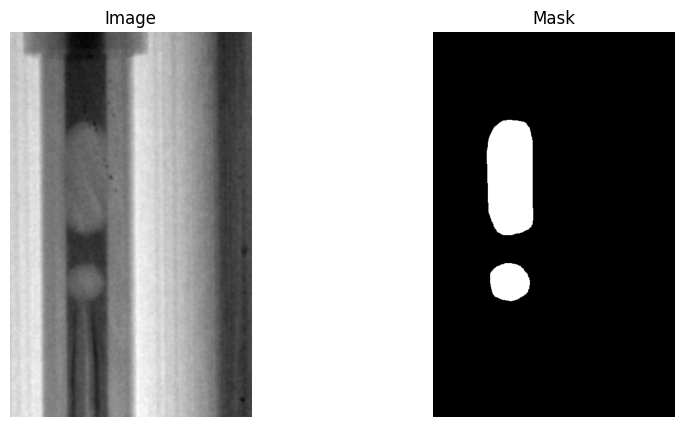

1


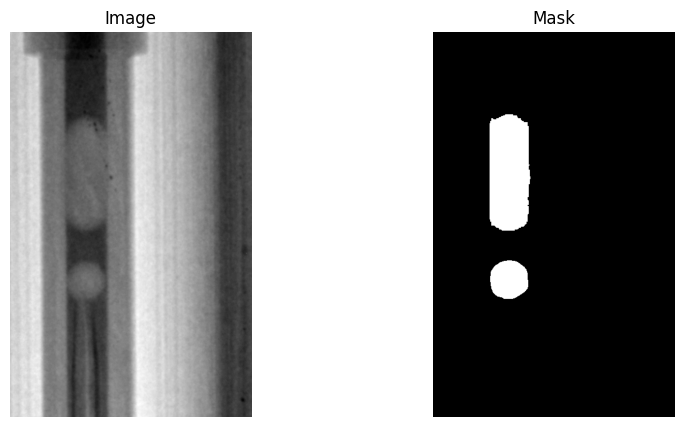

2


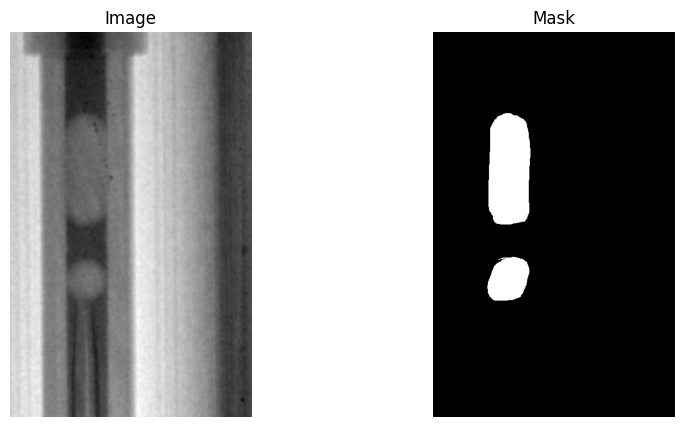

3


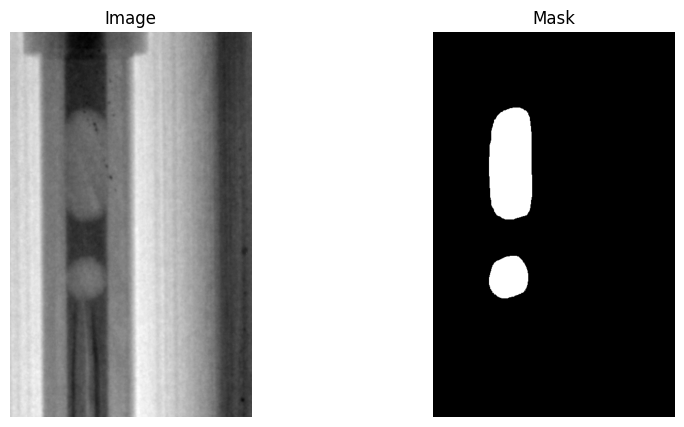

4


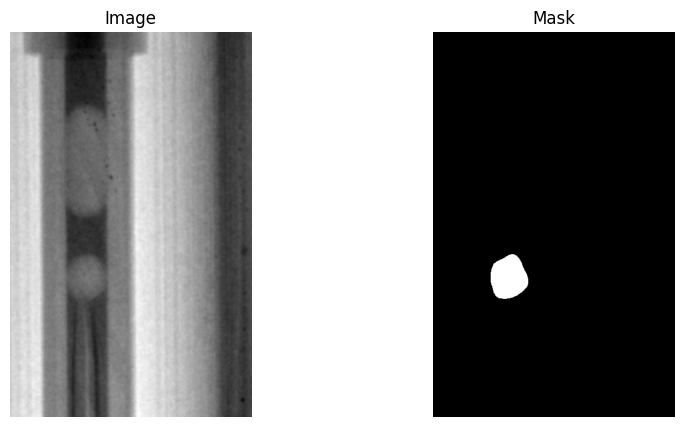

In [4]:
def display_images_and_masks(images, masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Image")
        plt.axis("off")
        print(i)
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.show()

# Display the images and masks
display_images_and_masks(image_dataset, mask_dataset)#


In [5]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
#mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
mask_dataset = np.expand_dims(np.array(mask_dataset), 3)

print(np.shape(image_dataset))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

(492, 688, 432, 1)


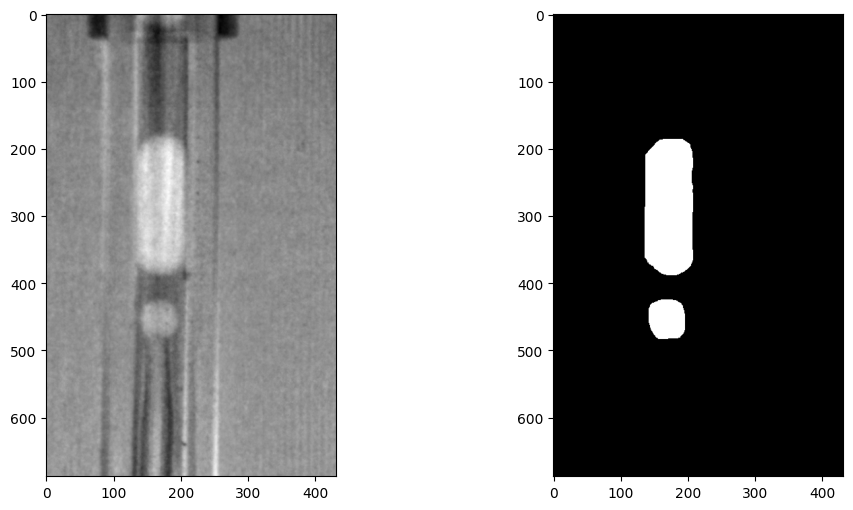

In [9]:
#Sanity check, view few mages
import random
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (688, 432)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (688, 432)), cmap='gray')
plt.show()


In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if inputs are normalized beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [11]:
# IMG_HEIGHT = image_dataset.shape[1]
# IMG_WIDTH  = image_dataset.shape[2]
# IMG_CHANNELS = image_dataset.shape[3]

IMG_HEIGHT = 688
IMG_WIDTH  = 432
IMG_CHANNELS = 1

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 688, 432, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 688, 432, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 688, 432, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
#If starting with pre-trained weights.
#model.load_weights('droplet_gpu_tf1.4.hdf5')

history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('/content/drive/MyDrive/Coalb_Notebooks/dropletonly.hdf5')

Epoch 1/50
28/28 [==============================] - 63s 1s/step - loss: 0.3541 - accuracy: 0.9202 - val_loss: 0.2593 - val_accuracy: 0.9348
Epoch 2/50
28/28 [==============================] - 22s 771ms/step - loss: 0.2122 - accuracy: 0.9326 - val_loss: 0.1995 - val_accuracy: 0.9348
Epoch 3/50
28/28 [==============================] - 22s 797ms/step - loss: 0.1718 - accuracy: 0.9326 - val_loss: 0.1928 - val_accuracy: 0.9348
Epoch 4/50
28/28 [==============================] - 23s 814ms/step - loss: 0.1259 - accuracy: 0.9326 - val_loss: 0.2119 - val_accuracy: 0.9348
Epoch 5/50
28/28 [==============================] - 23s 812ms/step - loss: 0.0860 - accuracy: 0.9326 - val_loss: 0.1694 - val_accuracy: 0.9348
Epoch 6/50
28/28 [==============================] - 22s 804ms/step - loss: 0.0698 - accuracy: 0.9591 - val_loss: 0.1488 - val_accuracy: 0.9378
Epoch 7/50
28/28 [==============================] - 22s 803ms/step - loss: 0.0652 - accuracy: 0.9846 - val_loss: 0.1076 - val_accuracy: 0.9609
Ep

2/2 [==============================] - 17s 6s/step - loss: 0.0260 - accuracy: 0.9909
Accuracy =  99.09431338310242 %


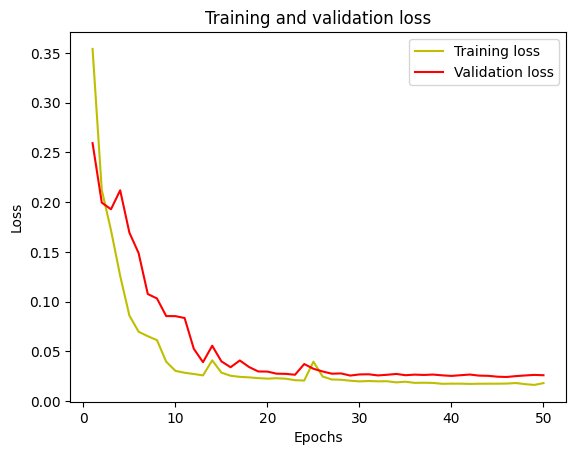

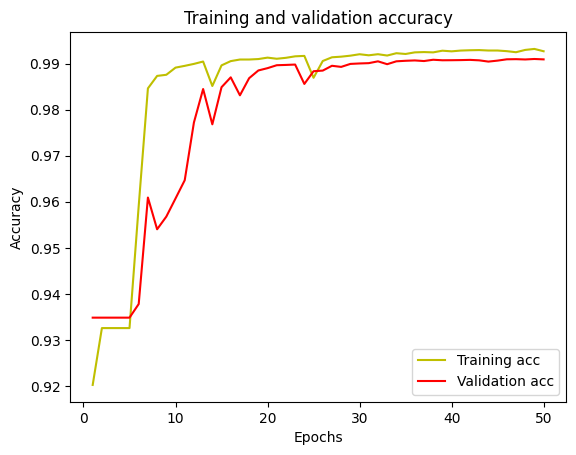

2/2 [==============================] - 1s 371ms/step
IoU socre is:  0.8558969953359549
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 688, 432, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 688, 432, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 688, 432, 16  0           ['conv2d_19[0][0]']              
     

FileNotFoundError: ignored

In [13]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.2

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)




#Predict on a few images
model = get_model()
model.load_weights('/content/drive/MyDrive/Coalb_Notebooks/droplet_test_kili.hdf5')


test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

test_img_other = cv2.imread('/content/drive/MyDrive/Coalb_Notebooks/Dataset/Images/scan_00000000_0027.png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.05).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')






In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


NameError: ignored

In [21]:
#Saving History
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# save to json:
hist_json_file = '/content/drive/MyDrive/Coalb_Notebooks/History/dropletonly.json'

In [ ]:

#Predict on a few images
model = get_model()
model.load_weights('/content/drive/MyDrive/Coalb_Notebooks/droplet_test_kili.hdf5')


test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

test_img_other = cv2.imread('/content/drive/MyDrive/Coalb_Notebooks/Dataset/Images/scan_00000000_0027.png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 688, 336, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 688, 336, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 688, 336, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

NameError: ignored

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 688, 432, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_380 (Conv2D)            (None, 688, 432, 16  160         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_180 (Dropout)          (None, 688, 432, 16  0           ['conv2d_380[0][0]']             
                                )                                                          

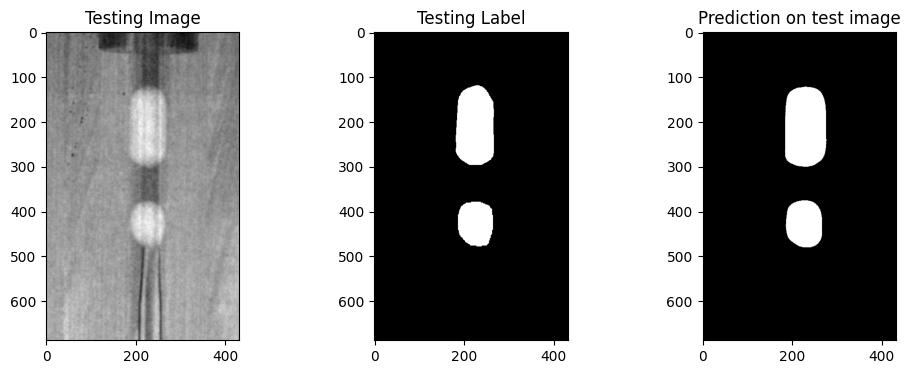

In [44]:
import random
model = get_model()
model.load_weights('/content/drive/MyDrive/Coalb_Notebooks/dropletonly.hdf5')

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.2).astype(np.uint8)

plt.figure(figsize=(12, 4))

# Display test image
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')

# Display ground truth
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='gray')

# Display prediction
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


1/1 [==============================] - 0s 62ms/step


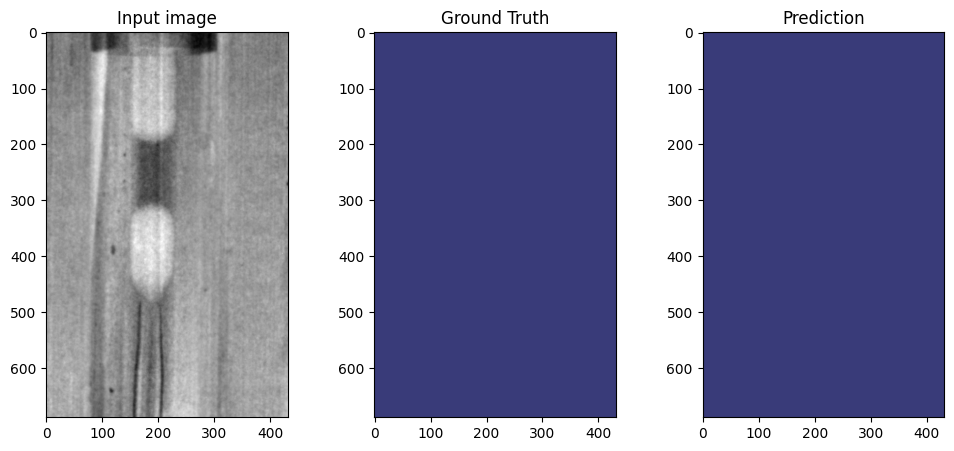

In [41]:
def plot_sample(X, y, prediction=None):
    """Function to plot the results"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(X.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y.argmax(axis=-1), cmap='tab20b')

    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(prediction.argmax(axis=-1), cmap='tab20b')

    plt.show()

# Generate a random index for visualization
index = random.randint(0, X_test.shape[0])

# Predict the mask from the model
predicted_mask = model.predict(np.expand_dims(X_test[index], axis=0))

# Plot the original image, the mask, and the predicted mask
plot_sample(X_test[index], y_test[index], predicted_mask[0])

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

def load_image_and_mask(image_file, mask_file):
    image = load_img(image_file, target_size=image_size)
    mask = load_img(mask_file, target_size=image_size, color_mode='grayscale')
    image = tf.keras.preprocessing.image.img_to_array(image)
    mask = tf.keras.preprocessing.image.img_to_array(mask)
    return image, mask

def normalize(images, masks):
    images = images / 255.0
    masks = masks / 255.0
    return images, masks

image_files = tf.data.Dataset.list_files(os.path.join(image_dir, "*.png"), shuffle=False)
mask_files = tf.data.Dataset.list_files(os.path.join(mask_dir, "*.png"), shuffle=False)

dataset = tf.data.Dataset.zip((image_files, mask_files))
dataset = dataset.map(lambda x, y: tf.py_function(load_image_and_mask, [x, y], [tf.float32, tf.float32]))
dataset = dataset.map(normalize)
dataset = dataset.batch(batch_size)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

In [ ]:
import matplotlib.pyplot as plt

def display_images_and_masks(images, masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(masks[i, :, :, 0], cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.show()

# Get the first batch from the dataset
images, masks = next(iter(dataset))

# Display the images and masks
display_images_and_masks(images, masks)


In [ ]:

image_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Images"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Masks"
batch_size = 8
image_size = (660, 1382)
seed = 42

# Create image dataset
image_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=image_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed
)

# Create mask dataset
mask_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=mask_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    color_mode='grayscale'
)

# Combine image and mask datasets
dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

# Normalize image and mask values
def normalize(images, masks):
    images = images / 255.0
    masks = masks / 255.0
    return images, masks

dataset = dataset.map(normalize)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.applications import VGG16

input_shape = (220, 460, 3)  # The input shape should match the resized image size

# Load the VGG16 model without the top layers
base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

# Set base model layers as non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a segmentation decoder
def create_decoder(base_model_output):
    x = UpSampling2D(size=(2, 2))(base_model_output)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return x

# Connect the base model with the decoder layers
decoder_output = create_decoder(base_model.output)
model = tf.keras.Model(inputs=base_model.input, outputs=decoder_output)


In [ ]:
# Train the model
epochs = 100
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(dataset, epochs=epochs)


In [ ]:
# Load COCO annotations
data_dir = "/content/drive/MyDrive/Colab Notebooks/Annotations/"
annotation_file = os.path.join(data_dir, "coco_300_1205.json")
coco = COCO(annotation_file)

# Create mask images from annotations
def create_mask(coco, image_id, save_dir):
    img_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_info["id"])
    anns = coco.loadAnns(ann_ids)

    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
      mask += coco.annToMask(anns[i])

    img_name = img_info["file_name"].split("-")[-1]

    mask_file = os.path.join(save_dir, "{}.png".format(img_name.split(".")[0]))
    cv2.imwrite(mask_file, mask)


mask_save_dir = "/content/drive/MyDrive/Colab Notebooks/Saves"
os.makedirs(mask_save_dir, exist_ok=True)

image_ids = coco.getImgIds()

for image_id in image_ids:
    create_mask(coco, image_id, mask_save_dir)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


IndexError: ignored

In [ ]:
# Load COCO annotations
data_dir = "/content/drive/MyDrive/Colab Notebooks/Annotations/"
annotation_file = os.path.join(data_dir, "coco_300_1205.json")
coco = COCO(annotation_file)

# Create mask images from annotations
def create_mask(coco, image_id, save_dir):
    img_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_info["id"])
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)

    for ann in anns:
        mask += coco.annToMask(ann)
    img_name = img_info["file_name"].split("-")[-1]

    mask_file = os.path.join(save_dir, "{}.png".format(img_name.split(".")[0]))


      if np.any(mask):
        success = cv2.imwrite(mask_file, mask)
        if success:
            print(f"Created mask for image ID {image_id}: {mask_file}")
        else:
            print(f"Failed to create mask for image ID {image_id}")
      else:
        print(f"Mask for image ID {image_id} is empty")

mask_save_dir = "/content/drive/MyDrive/Colab Notebooks/Saves"
os.makedirs(mask_save_dir, exist_ok=True)

image_ids = coco.getImgIds()

for image_id in image_ids:
    create_mask(coco, image_id, mask_save_dir)


In [ ]:
class CocoLikeDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            # if class_id < 1:
            #     print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
            #     return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids





In [ ]:
input_file = '/content/drive/MyDrive/Colab Notebooks/Annotations/project-1-at-2023-05-13-15-33-732c8109.csv'
output_file = '/content/drive/MyDrive/Colab Notebooks/Annotations/project-1preproc.csv'

with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:
        if line.startswith('updated_at'):
            outfile.write(line)  # Write header without modification
            continue

        fields = line.split(',')
        label_field = fields[1]

        if label_field.startswith('[') and label_field.endswith(']'):
            label_field = label_field.replace(',', ';')
            label_field = f'"{label_field}"'
            fields[1] = label_field

        new_line = ','.join(fields)
        outfile.write(new_line)


In [ ]:
annotations_df = pd.read_csv(output_file)

ParserError: ignored

In [ ]:
points = []
polygons = []

for index, row in annotations_df.iterrows():
    if row['type'] == 'point':
        points.append({'image_id': row['image_id'], 'x': row['x'], 'y': row['y']})
    elif row['type'] == 'polygon':
        polygons.append({'image_id': row['image_id'], 'vertices': eval(row['vertices'])})


In [ ]:
image_dir = 'path/to/your/image_directory'
image_ids = annotations_df['image_id'].unique()
batch_size = 16
image_size = (256, 256)

# You can use a preprocessing function from a pre-trained model if needed
preprocessing_function = tf.keras.applications.vgg16.preprocess


In [ ]:
import numpy as np
import cv2
import tensorflow as tf

def create_mask(image_shape, polygons):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for polygon in polygons:
        pts = np.array(polygon['vertices'], np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

def data_generator(image_dir, image_ids, points, polygons, batch_size, image_size, preprocessing_function=None):
    while True:
        # Shuffle the image ids
        np.random.shuffle(image_ids)

        # Create empty arrays for batch data
        batch_images = np.zeros((batch_size, *image_size, 3))
        batch_masks = np.zeros((batch_size, *image_size))

        for i in range(batch_size):
            # Get a random image id
            image_id = np.random.choice(image_ids)

            # Read and resize the image
            image_path = f'{image_dir}/{image_id}.jpg'
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)

            # Get the corresponding polygons
            image_polygons = [p for p in polygons if p['image_id'] == image_id]

            # Create the mask
            mask = create_mask(image.shape, image_polygons)
            mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)

            # Preprocess the image if needed
            if preprocessing_function is not None:
                image = preprocessing_function(image)

            batch_images[i] = image
            batch_masks[i] = mask

        yield batch_images, batch_masks[..., np.newaxis]


In [ ]:
def preprocess_image(image_path, target_size=(330, 691)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return image

In [ ]:
def dataset_generator(annotations_data):
    for annotation in annotations_data:
        image_path = "Data/" + annotation['externalID']
        image = preprocess_image(image_path)
        target = preprocess_annotation(annotation)
        yield image, target

In [ ]:
dataset = tf.data.Dataset.from_generator(
    dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(330, 691 , 3), dtype=tf.float32),
        # Update the shape and dtype according to your annotation preprocessing
        tf.TensorSpec(shape=(3), dtype=tf.float32)
    ),
    args=(annotations_data,)
)

# Shuffle, batch, and prefetch the dataset
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


ValueError: ignored

In [ ]:
#Resize images (height  = X, width = Y)
SIZE_Y = 128
SIZE_X = 128


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (SIZE_X, SIZE_Y),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

NameError: ignored

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_batches, 3)